# Forecasting moss & lichen fractional cover 
## with a Neural Network using Keras
## (Reading X and Y train/test files stored locally)
### Using only 2m temperature and total precipitation from ERA5-land
### For lichen output only

In [2]:
pip install tensorflow tables --quiet

Note: you may need to restart the kernel to use updated packages.


In [43]:
print('Starting imports')
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn  as sns
from tensorflow.keras.layers import Input, BatchNormalization, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
print('Finished imports')

Starting imports
Finished imports


In [244]:
# print('Defining various parameters')

depth = 8
width = 32
epochs = 128
activation = 'relu'
final_activation = 'sigmoid'
batch_size = 64
learning_rate = 0.0005
loss = 'LogCosh'
validation_split = 0.2
print('Depth = ', depth)
print('Width = ', width)
print('Hidden layer activation = ', activation)
print('Final activation = ', final_activation)
print('Learning rate = ', learning_rate)
print('Epochs = ', epochs)
print('Batch size = ', batch_size)
print('Loss function = ', loss)
print('Validation split = ', validation_split)
expname = 'TP2_twice_' + str(depth) + '_' + str(width) + '_' + str(epochs) + 'epochs-' + str(batch_size) + '_' + activation + '-' + final_activation + '-' + str(learning_rate) + '-' + loss + '-' + str(validation_split)
print('Experiment name = ', expname)

Depth =  8
Width =  32
Hidden layer activation =  relu
Final activation =  sigmoid
Learning rate =  0.0005
Epochs =  128
Batch size =  64
Loss function =  LogCosh
Validation split =  0.2
Experiment name =  TP2_twice_8_32_128epochs-64_relu-sigmoid-0.0005-LogCosh-0.2


# **All years** of input/output data - for training

In [251]:
# Read local .hdf5 file
path = '/home/jovyan/Arctic/Vegetation_in_Troms_and_Finnmark/data/'

print('Reading X_train')
X_train_file = os.path.join(path, 'X_mean_tp2_train.hdf')
input_train = pd.read_hdf(X_train_file)
input_train.fillna(0, inplace=True)

print('Reading X_test')
X_test_file = os.path.join(path, 'X_mean_tp2_test.hdf')
input_test = pd.read_hdf(X_test_file)
input_test.fillna(0, inplace=True)

print('Reading y_train')
y_train_file = os.path.join(path, 'y_mean_tp2_train.hdf')
output_train = pd.read_hdf(y_train_file)
output_train.fillna(0, inplace=True)

print('Reading y_test')
y_test_file = os.path.join(path, 'y_mean_tp2_test.hdf')
output_test = pd.read_hdf(y_test_file)
output_test.fillna(0, inplace=True)

Reading X_train
Reading X_test
Reading y_train
Reading y_test


In [252]:
# Drop tp from inputs
#input_train.drop(input_train.columns[range(183 * 24 +1, 183 * 24 * 2 +1)], axis=1, inplace=True)
#input_test.drop(input_test.columns[range(183 * 24 +1, 183 * 24 * 2 +1)], axis=1, inplace=True)

In [253]:
input_test

,Lichen_mean,t2m_0,t2m_1,t2m_2,t2m_3,t2m_4,t2m_5,t2m_6,t2m_7,t2m_8,...,tp_4382,tp_4383,tp_4384,tp_4385,tp_4386,tp_4387,tp_4388,tp_4389,tp_4390,tp_4391
1358,0.177978,0.980135,0.979505,0.978143,0.975644,0.976013,0.976317,0.977548,0.978788,0.979587,...,1.491984e-01,1.494203e-01,1.494203e-01,1.494203e-01,1.494203e-01,1.494203e-01,1.494203e-01,1.494203e-01,1.494203e-01,1.494203e-01
2200,0.157500,0.943982,0.941230,0.939253,0.937611,0.935943,0.935148,0.935330,0.937988,0.938927,...,2.212822e-04,2.212822e-04,2.212822e-04,2.212822e-04,4.431233e-04,4.431233e-04,4.431233e-04,4.431233e-04,4.431233e-04,4.431233e-04
2337,0.020000,0.959458,0.959376,0.959449,0.959516,0.959092,0.959678,0.960206,0.966640,0.968628,...,2.212822e-04,2.212822e-04,2.212822e-04,2.212822e-04,4.431233e-04,4.431233e-04,4.431233e-04,4.431233e-04,4.431233e-04,4.431233e-04
3639,0.099167,0.972789,0.973408,0.973980,0.974437,0.974493,0.974899,0.975942,0.984269,0.987706,...,1.605045e-01,1.984142e-01,2.145974e-01,2.267908e-01,2.409792e-01,2.420872e-01,2.462994e-01,2.582710e-01,2.791101e-01,3.218964e-01
2928,0.229740,0.985534,0.986710,0.988236,0.990557,0.991591,0.993561,0.993910,0.992570,0.991065,...,1.564481e+00,1.687742e+00,1.836275e+00,1.929385e+00,1.978379e+00,2.123366e+00,2.302715e+00,2.472088e+00,2.596457e+00,2.693337e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,0.200000,0.978986,0.978176,0.978027,0.978107,0.978620,0.978533,0.978254,0.977475,0.976468,...,-5.587935e-07,-5.587935e-07,-5.587935e-07,-5.587935e-07,-5.587935e-07,-5.587935e-07,-5.587935e-07,-5.587935e-07,-5.587935e-07,-5.587935e-07
2415,0.070400,0.940165,0.939883,0.939550,0.938421,0.938721,0.938738,0.940493,0.947097,0.949475,...,2.212822e-04,2.212822e-04,2.212822e-04,2.212822e-04,4.431233e-04,4.431233e-04,4.431233e-04,4.431233e-04,4.431233e-04,4.431233e-04
981,0.062381,0.977655,0.977943,0.977446,0.975831,0.976683,0.977936,0.978183,0.975156,0.972139,...,1.928676e-02,1.928676e-02,1.928676e-02,1.928676e-02,1.928676e-02,1.928676e-02,1.928676e-02,1.928676e-02,1.928676e-02,1.928676e-02
1944,0.037571,0.968520,0.968074,0.968311,0.969230,0.970650,0.972682,0.974349,0.979942,0.980914,...,2.212822e-04,2.212822e-04,2.212822e-04,2.212822e-04,4.431233e-04,4.431233e-04,4.431233e-04,4.431233e-04,4.431233e-04,4.431233e-04


In [254]:
def fullyconnected_sequential(
    input_shape: int,  # How many predictors?
    width: int,  # How wide should the layers be?
    depth: int,  # How many layers?
    activation: str,  # What nonlinearity to use?
    final_activation: str,  # Output layer?
    learning_rate: float,  # What learning rate?
    loss: str,  # What loss function?
):
    # Create a model object
    model = Sequential()

    # Then just stack layers on top of one another
    # the first specifies the shape of the inputs expected input
    model.add(Input(input_shape, name = 'Inputs'))

    # Then we stack on depth number of consectutive dense layers
    # To write more compact code we can include the activation
    # function we want to apply after each Dense block in the
    # call itself.
    for i in range(depth):
        model.add(Dense(width, activation = activation))

    # Finally we add an output layer, we want to predict
    # 1 variable, and we will probably use a linear output
    # layer, so we don't constrain the output
    model.add(Dense(1, activation = final_activation))

    # Next we need to specify the optimiser we want to use and what learning rate to use
    opt = SGD(learning_rate)

    # Finally we compile the model, specifying the loss we want to minimise
    model.compile(loss = loss, optimizer = opt)

    # Afterwards we can summarise the model to see the shapes
    model.summary()
    return model

# Model Building

In [255]:
model = fullyconnected_sequential(input_train.shape[1], depth=depth, width=width, activation=activation, final_activation=final_activation, learning_rate=learning_rate, loss=loss)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_121 (Dense)           (None, 32)                281152    
                                                                 
 dense_122 (Dense)           (None, 32)                1056      
                                                                 
 dense_123 (Dense)           (None, 32)                1056      
                                                                 
 dense_124 (Dense)           (None, 32)                1056      
                                                                 
 dense_125 (Dense)           (None, 32)                1056      
                                                                 
 dense_126 (Dense)           (None, 32)                1056      
                                                                 
 dense_127 (Dense)           (None, 32)              

# Model training

In [256]:
# Sequential
history = model.fit(input_train, output_train, validation_split = validation_split, batch_size = batch_size, epochs = epochs)

Epoch 1/128
39/39 [==============================] - 1s 14ms/step - loss: 0.0619 - val_loss: 0.0601
Epoch 2/128
39/39 [==============================] - 0s 9ms/step - loss: 0.0587 - val_loss: 0.0565
Epoch 3/128
39/39 [==============================] - 0s 8ms/step - loss: 0.0550 - val_loss: 0.0525
Epoch 4/128
39/39 [==============================] - 0s 8ms/step - loss: 0.0508 - val_loss: 0.0483
Epoch 5/128
39/39 [==============================] - 0s 8ms/step - loss: 0.0465 - val_loss: 0.0440
Epoch 6/128
39/39 [==============================] - 0s 9ms/step - loss: 0.0422 - val_loss: 0.0399
Epoch 7/128
39/39 [==============================] - 0s 11ms/step - loss: 0.0381 - val_loss: 0.0357
Epoch 8/128
39/39 [==============================] - 0s 10ms/step - loss: 0.0340 - val_loss: 0.0317
Epoch 9/128
39/39 [==============================] - 0s 7ms/step - loss: 0.0300 - val_loss: 0.0279
Epoch 10/128
39/39 [==============================] - 0s 8ms/step - loss: 0.0263 - val_loss: 0.0242
Epoch 

Generating the history loss plot


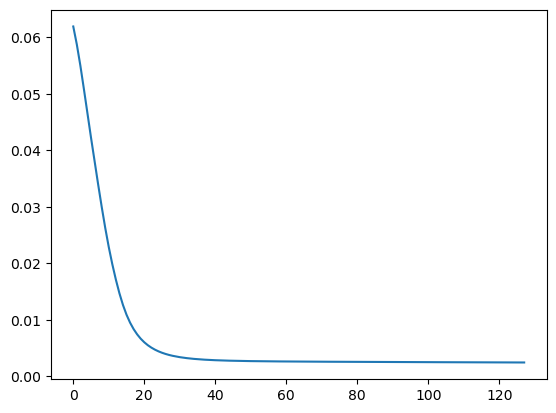

In [257]:
# Plot the loss history
print('Generating the history loss plot')
lineplot = sns.lineplot(x=history.epoch, y=history.history['loss'])
fig = lineplot.get_figure()
loss_fig_file = os.path.join(path, 'outputs/' + expname + '_loss.png')
fig.savefig(loss_fig_file) 

In [258]:
# Model performance on the whole training data
train_loss = model.evaluate(input_train, output_train)
print("Training Mean Squared Error:", train_loss)

97/97 [==============================] - 0s 3ms/step - loss: 0.0024
Training Mean Squared Error: 0.0024063903838396072


In [259]:
# Model performance on testing data (unseen)
val_loss = model.evaluate(input_test, output_test)
print("Validation  Mean Squared Error:", val_loss)

25/25 [==============================] - 0s 3ms/step - loss: 0.0024
Validation  Mean Squared Error: 0.002360043115913868


In [260]:
# Save model
model_file = os.path.join(path, 'outputs/' + expname + '.h5')
model.save(model_file)

In [261]:
# Perform a prediction
print('Forecasting', input_test.sum())
output_test_forecast = model.predict(input_test)

Forecasting Lichen_mean     91.663531
t2m_0          749.171763
t2m_1          748.941044
t2m_2          748.845521
t2m_3          748.779360
                  ...    
tp_4387        788.367348
tp_4388        818.224387
tp_4389        840.850506
tp_4390        861.786661
tp_4391        882.249293
Length: 8785, dtype: float64
25/25 [==============================] - 0s 3ms/step


In [262]:
output_test_forecast = pd.DataFrame(output_test_forecast.tolist())

In [263]:
output_test_forecast.columns = ['Forecasted_lichen']

In [264]:
output_test = output_test.reset_index().drop(columns=['index'])

In [265]:
output_test.columns = ['Actual_lichen']

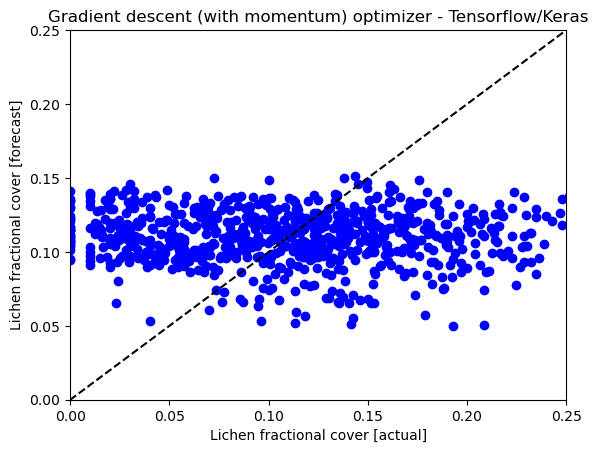

In [266]:
# Predictions vs. True Values XY-PLOT

fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(output_test, output_test_forecast, marker = 'o', c = 'blue')
plt.plot([-5,20], [-5,20], color = 'black', ls = '--')

plt.ylabel('Lichen fractional cover [forecast]')
plt.xlabel('Lichen fractional cover [actual]')
plt.title('Gradient descent (with momentum) optimizer - Tensorflow/Keras')

plt.ylim(0., 0.25)
plt.xlim(0., 0.25)

plt.axis(True)
plt.show()

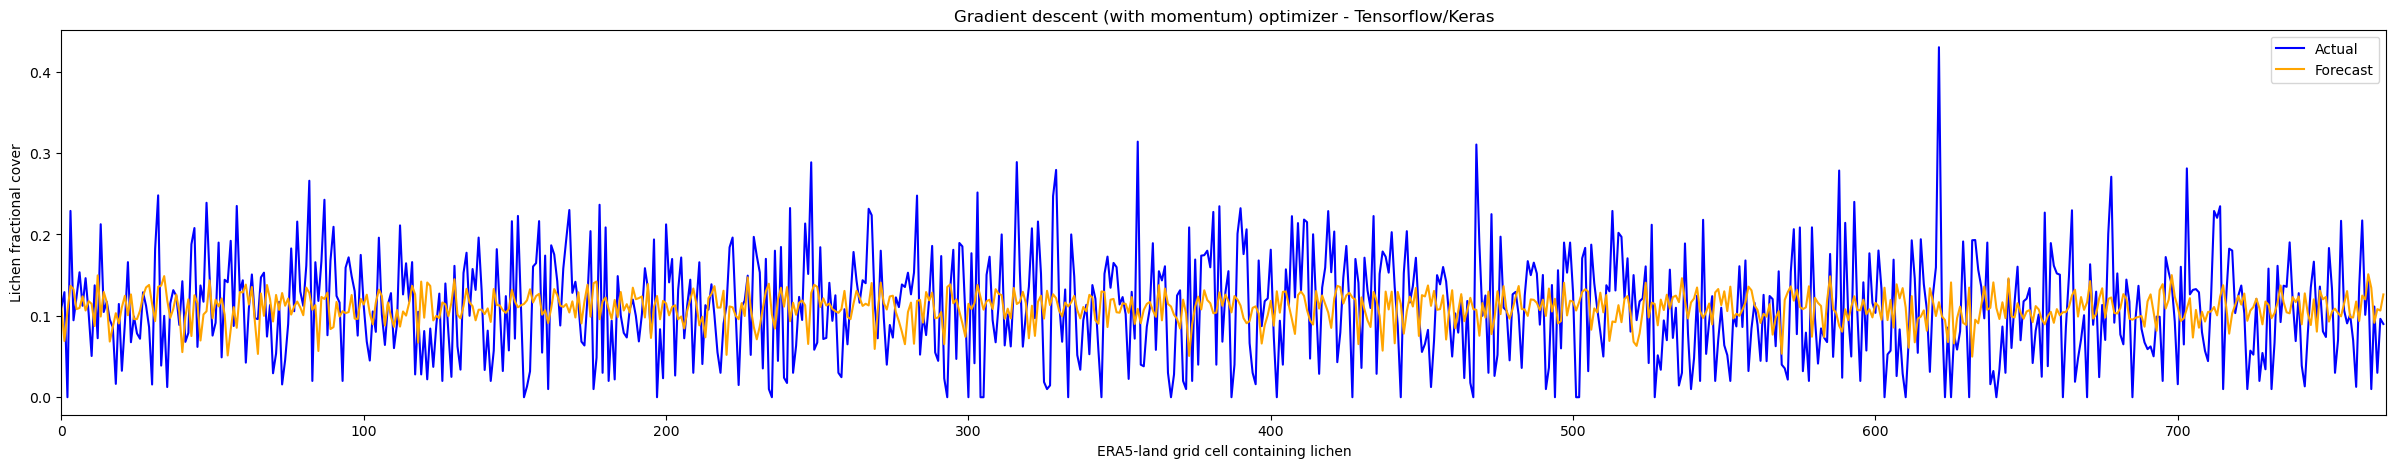

In [267]:
# Predictions vs. True Values PLOT

fig = plt.figure(figsize=(30, 5))
ax = fig.add_subplot(111)

plt.plot(output_test, c = 'blue')
plt.plot(output_test_forecast, c = 'orange')

plt.ylabel('Lichen fractional cover')
plt.xlabel('ERA5-land grid cell containing lichen')
plt.title('Gradient descent (with momentum) optimizer - Tensorflow/Keras')

plt.xlim(0., len(output_test))
ax.legend(['Actual', 'Forecast'])